# SBD on nuclear shell model

In [1]:
from src.hamiltonian_utils import FermiHubbardHamiltonian
from src.utils_quasiparticle_approximation import HardcoreBosonsBasis
from src.nuclear_physics_utils import get_twobody_nuclearshell_model,SingleParticleState
import numpy as np
import torch
from typing import Dict
import scipy
from src.qml_models import AdaptVQEFermiHubbard
from src.qml_utils.train import Fit
from src.qml_utils.utils import configuration
from scipy.sparse.linalg import eigsh,expm_multiply
from tqdm import trange
import matplotlib.pyplot as plt
from src.fermi_hubbard_library import FemionicBasis
import numpy as np
from typing import List, Dict
from scipy.linalg import expm
import scipy
from scipy.sparse.linalg import expm_multiply
from scipy.optimize import minimize
from scipy.sparse import coo_matrix
from scipy.sparse import lil_matrix
from scipy.optimize import minimize
from scipy import sparse
from src.hartree_fock_library import HFEnergyFunctional,HFEnergyFunctionalNuclear
import torch
import torch.nn as nn
import torch.optim as optim


file_name='data/usdb.nat'

SPS=SingleParticleState(file_name=file_name)

In [2]:
nparticles_a=8
nparticles_b=2 # Berillium

size_a=SPS.energies.shape[0]//2
size_b=SPS.energies.shape[0]//2

title=r'$^{20}$O'

Exact solution:

In [3]:

# Compute the J^2 value
#J2Class=J2operator(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b,single_particle_states=SPS.state_encoding,j_square_filename=file_name+'_j2',symmetries=[SPS.total_M_zero])

#Quadrupole Operator


# compute the NSM Hamiltonian
NSMHamiltonian=FermiHubbardHamiltonian(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b,symmetries=[SPS.total_M_zero])
print('size=',size_a+size_b,size_b)
NSMHamiltonian.get_external_potential(external_potential=SPS.energies[:size_a+size_b])
if file_name=='data/cki':
    twobody_matrix,energies=get_twobody_nuclearshell_model(file_name=file_name)

    NSMHamiltonian.get_twobody_interaction(twobody_dict=twobody_matrix)
else:
    NSMHamiltonian.twobody_operator=scipy.sparse.load_npz(f'data/nuclear_twobody_matrix/usdb_{nparticles_a}_{nparticles_b}.npz')
NSMHamiltonian.get_hamiltonian()

####
H = NSMHamiltonian.hamiltonian # hamiltonian as sparse matrix
basis = NSMHamiltonian.basis # basis
###

egs,psi0=NSMHamiltonian.get_spectrum(n_states=1) # exact solution, later to confront
psi0 = psi0.reshape(-1)

print(egs)

print('total_m=',SPS.compute_m_exp_value(psi=psi0,basis=NSMHamiltonian.basis))
#print('j_value=',J2Class.j_value(psi0))
print('dimension=',NSMHamiltonian.hamiltonian.shape[0])

size= 24 12
[-87.14199175]
total_m= 3.4778272841755114e-17
dimension= 4206


Hartree-Fock

Load the two-body matrix

In [4]:
twobody_matrix,energies=get_twobody_nuclearshell_model(file_name=file_name)

Computing the matrix, pls wait... (u_u) 



  0%|          | 0/24 [00:00<?, ?it/s]

100%|██████████| 24/24 [00:42<00:00,  1.77s/it]


In [5]:

#model=HFEnergyFunctional(h_vec=torch.tensor(SPS.energies),V_dict=twobody_matrix,num_particles=nparticles_a+nparticles_b)
model=HFEnergyFunctionalNuclear(h_vec=torch.tensor(SPS.energies,dtype=torch.double),V_dict=twobody_matrix,num_neutrons=nparticles_a,num_protons=nparticles_b,neutron_indices=0,proton_indices=size_a)

optimizer = optim.Adam(model.parameters(), lr=0.01)

num_steps = 600
for step in range(num_steps):
    optimizer.zero_grad()
    energy = model()  # calls forward()
    energy.backward()
    optimizer.step()

    if step % 20 == 0 or step == num_steps - 1:
        print(f"Step {step:4d} | Energy = {energy.item():.6f}")

Step    0 | Energy = -56.338533
Step   20 | Energy = -64.394532
Step   40 | Energy = -69.524326
Step   60 | Energy = -72.546284
Step   80 | Energy = -75.042151
Step  100 | Energy = -76.881880
Step  120 | Energy = -78.032256
Step  140 | Energy = -78.893733
Step  160 | Energy = -79.574530
Step  180 | Energy = -80.063099
Step  200 | Energy = -80.373435
Step  220 | Energy = -80.553356
Step  240 | Energy = -80.653373
Step  260 | Energy = -80.709237
Step  280 | Energy = -80.741421
Step  300 | Energy = -80.760625
Step  320 | Energy = -80.772438
Step  340 | Energy = -80.779925
Step  360 | Energy = -80.784836
Step  380 | Energy = -80.788196
Step  400 | Energy = -80.790605
Step  420 | Energy = -80.792417
Step  440 | Energy = -80.793837
Step  460 | Energy = -80.794990
Step  480 | Energy = -80.795950
Step  500 | Energy = -80.796764
Step  520 | Energy = -80.797462
Step  540 | Energy = -80.798064
Step  560 | Energy = -80.798586
Step  580 | Energy = -80.799038
Step  599 | Energy = -80.799412


In [6]:
def slater_determinants_combined(C_n, C_p, fock_basis):
    """
    C_n: [M_half, N_n]  -- neutron orbitals
    C_p: [M_half, N_p]  -- proton orbitals
    fock_basis: [F, M]  -- full occupation basis (neutrons + protons)

    Returns:
        psi: [F]  -- Slater determinant amplitudes
    """
    F, M = fock_basis.shape
    M_half = M // 2
    N_n = C_n.shape[1]
    N_p = C_p.shape[1]

    psi = torch.zeros(F, dtype=C_n.dtype)

    for i in range(F):
        occ = fock_basis[i]  # [M]

        occ_n = torch.nonzero(occ[:M_half]).squeeze()
        occ_p = torch.nonzero(occ[M_half:]).squeeze()+M_half

        Cn_sub = C_n[occ_n, :]  # shape [N_n, N_n]
        Cp_sub = C_p[occ_p, :]  # shape [N_p, N_p]

        if Cn_sub.shape[0] != N_n or Cp_sub.shape[0] != N_p:
            # Skip invalid configurations (e.g., wrong number of particles)
            continue

        det_n = torch.det(Cn_sub)
        det_p = torch.det(Cp_sub)
        psi[i] = det_n * det_p


    return psi  # [F]

def slater_determinants_only_neutrons(C_n, fock_basis):
    """
    C_n: [M_half, N_n]  -- neutron orbitals
    C_p: [M_half, N_p]  -- proton orbitals
    fock_basis: [F, M]  -- full occupation basis (neutrons + protons)

    Returns:
        psi: [F]  -- Slater determinant amplitudes
    """
    F, M = fock_basis.shape
    M_half = M // 2
    N_n = C_n.shape[1]


    psi = torch.zeros(F, dtype=C_n.dtype)

    for i in range(F):
        occ = fock_basis[i]  # [M]

        occ_n = torch.nonzero(occ[:M_half]).squeeze()


        Cn_sub = C_n[occ_n, :]  # shape [N_n, N_n]




        det_n = torch.det(Cn_sub)

        psi[i] = det_n 

    return psi  # [F]


In [7]:

#psi_hf=slater_determinants_only_neutrons(model.C_n, torch.tensor(NSMHamiltonian.basis))
psi_hf=slater_determinants_combined(model.C_n, model.C_p, torch.tensor(NSMHamiltonian.basis))

psi_hf=psi_hf.detach().numpy()

psi_hf=psi_hf/np.linalg.norm(psi_hf)

In [8]:


print(psi_hf.conjugate() @ NSMHamiltonian.hamiltonian @ psi_hf)
print(psi_hf.shape)
print('fidelity=',psi0[:].conjugate().dot(psi_hf)*np.conjugate(psi0[:].conjugate().dot(psi_hf)))

-81.70799059220816
(4206,)
fidelity= 0.27272001553473485


Voglio una classe Nuclear shell model sqd ansatz (trova un nome migliore hahah), i suoi parametri sono H e la base oppure numero particelle e per il resto fa automatico. Voglio i seguenti metodi:
- Inizializzazione stato con lo stato della base con minore energia
- Creazione operator pool
- compute state con produttoria delle unitarie ottenute esponenziando la somma degli operatori nell'operator pool sommati con il loro complesso coniugato fatta con scipy exp multiply applicato a stato precedente (se prima iter a quello dell'inizializzazione)
- fare SQD con quello stato e stimare energia con SQD

In secondo momento sarà da aggiungere anche minimizzazione energia!!!


In [ ]:
import itertools
from scipy.optimize import dual_annealing
from typing import Optional

def genera_ij(N): # crea lista indici (0,1),(0,2),..,(0,N-1),(1,2),....,(N-2,N-1) con N input
    return [(i, j) for i in range(N) for j in range(i + 1, N)]


def genera_i1i2j1j2(N):
    """
    Restituisce una lista di tuple (i1, i2, j1, j2) con valori unici tra 0 e N-1
    ed evita ripetizioni causate da permutazioni interne.
    """
    result = set()
    indices = range(N)

    for comb in itertools.combinations(indices, 4):  # scegli 4 indici distinti
        for split in itertools.combinations(comb, 2):  # scegli 2 per il primo "pair"
            # ottieni i1, i2 dal primo gruppo; j1, j2 dagli altri due
            i1, i2 = sorted(split)
            rest = [x for x in comb if x not in (i1, i2)]
            j1, j2 = sorted(rest)

            # crea una tupla canonica: (i1, i2, j1, j2)
            tup = (i1, i2, j1, j2)
            result.add(tup)

    return sorted(result)


class NSM_SQD_circuit_ansatz:

    def __init__(self, file_name = 'data/cki', nparticles_a=4, nparticles_b=2,M=None, samples = 20, batches =100, train_steps = 10,num_parameters=30,twobody_matrix:Optional[Dict]=None):
        self.M = M
        if self.M == 0:
            # compute the NSM Hamiltonian and the basis
            self.NSMHamiltonian=FermiHubbardHamiltonian(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b,symmetries=[SPS.total_M_zero])
            print('size=',size_a+size_b,size_b)
            self.NSMHamiltonian.get_external_potential(external_potential=SPS.energies[:size_a+size_b])
            if file_name=='data/cki':
                twobody_matrix,energies=get_twobody_nuclearshell_model(file_name=file_name)
                self.twobody_matrix=twobody_matrix
                self.NSMHamiltonian.get_twobody_interaction(twobody_dict=twobody_matrix)
            else:
                self.twobody_matrix=twobody_matrix
                self.NSMHamiltonian.twobody_operator=scipy.sparse.load_npz(f'data/nuclear_twobody_matrix/usdb_{nparticles_a}_{nparticles_b}.npz')
            self.NSMHamiltonian.get_hamiltonian()

        else:
            # compute the NSM Hamiltonian and the basis
            self.NSMHamiltonian=FermiHubbardHamiltonian(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b,symmetries=[])
            print('size=',size_a+size_b,size_b)
            self.NSMHamiltonian.get_external_potential(external_potential=SPS.energies[:size_a+size_b])
            if file_name=='data/cki':
                twobody_matrix,energies=get_twobody_nuclearshell_model(file_name=file_name)
                self.twobody_matrix=twobody_matrix
                self.NSMHamiltonian.get_twobody_interaction(twobody_dict=twobody_matrix)
            else:
                self.twobody_matrix=twobody_matrix
                self.NSMHamiltonian.twobody_operator=scipy.sparse.load_npz(f'data/nuclear_twobody_matrix/usdb_{nparticles_a}_{nparticles_b}.npz')
            self.NSMHamiltonian.get_hamiltonian()

        ####
        self.H = NSMHamiltonian.hamiltonian # hamiltonian as sparse matrix
        self.basis = NSMHamiltonian.basis # basis
        ###

        self.l = len(self.basis[0]) # lunghezza un elemento base
        self.operator_pool = {} # op pool as dict where key is (i,j)
        self.operator_pool_list = [] # op pool as list 
        self.psi = np.zeros(len(self.basis))
        self.E = 0.

        self.seed = 1024

        self.samples = samples # number of samples for sqd energy estimation
        self.batches = batches # different batches for sqd to make an average of the energy
        self.train_steps = train_steps # steps in optimization
        self.num_parameters = num_parameters # number of parameters in the ansatz

    def initialize_state_v1(self): # ref state is the element of the basis with the minimum energy
        self.psi = np.zeros(len(self.basis))  
        diag = self.H.diagonal()
        min_state_idx = diag.argmin()
        self.psi[min_state_idx] = 1. 
        self.psi /= np.linalg.norm(self.psi)
        self.E = diag.min()
        return None

    def initialize_state_v2(self,ns): # ref state is the element of the basis with the minimum energy
        self.psi = np.zeros(len(self.basis)) 
        diag = self.H.diagonal()
        min_indices = np.argsort(diag)[:ns]
        self.psi[min_indices] = 1. / np.sqrt(ns)
        self.psi /= np.linalg.norm(self.psi)
        self.E = diag[min_indices].mean()
        return None

    def initialize_state_v3(self,psi_hf): # ref state is the element of the basis with the minimum energy
        self.psi = psi_hf
        self.E = self.psi.transpose().conj() @ self.H @ self.psi
        return None


    def create_operator_pool_twobody_symmetry(self,original_operator_pool): # nella pool two body op che rispettano i miquel constraints
        #self.operator_pool:Dict={}
        #self.operator_pool = self.NSMHamiltonian.set_operator_pool(operator_pool=self.operator_pool,conditions=[SPS.projection_conservation,self.miquel_constrainer_2,self.miquel_constrainer,self.miquel_constrainer_3],nbody='two')
        self.operator_pool=original_operator_pool
        vs, ops, keys = [], [], []
        for key, op in self.operator_pool.items():
            if key in self.twobody_matrix:
                vs.append(self.twobody_matrix[key])
                ops.append(op)
                keys.append(key)

        vs = np.abs(np.array(vs))
        selection = np.argsort(vs)[-self.num_parameters:][::-1]
        selected_vs = vs[selection]


        new_operator_pool = {keys[idx]: ops[idx] for idx in selection}
        self.operator_pool = new_operator_pool
        self.operator_pool_list = list(self.operator_pool.values())
        np.random.seed(self.seed) 
        self.weights = np.zeros(len(self.operator_pool))#np.random.uniform(-1.3, 1.3, size=len(self.operator_pool))
        return None

    def forward(self, weights): # compute psi
        psi = self.psi.copy()
        if self.weights is not(None):
            
            for i, w in enumerate(weights):
                # print(np.conj(expm(self.weights[i] * op).T) @ expm(self.weights[i] * op))
                psi = scipy.sparse.linalg.expm_multiply( (0. + 1j) * w * self.operator_pool_list[i],psi) 
                psi = psi / np.linalg.norm(psi)

        return psi

    def SQD(self, weights): #output è energia stimata con SQD (compute energy functional)
        psi = self.forward(weights)
        prob = (np.conjugate(psi) * psi).real # .real needed to change data type from complex to float
        Ham = self.H.copy()
        np.random.seed(self.seed) # seed con cui calcolo il vettore random i cui elementi sono i seed dei diversi batch
        seeds = np.random.randint(1, 30002, size=self.batches)
        e = np.zeros(self.batches)
        self.psi_batches=np.zeros((self.batches,self.psi.shape[0]))
        for k,s in enumerate(seeds):
            np.random.seed(s)
            #print('non zero prob=',np.nonzero(prob)[0].shape[0])

            
            if np.nonzero(prob)[0].shape[0]<self.samples:
                raw_selection = np.random.choice(len(self.basis), size=self.samples * 5, replace=True, p=prob)
                # oversample to increase chance of enough unique values
                selection = []
                seen = set()
                for idx in raw_selection:
                    if idx not in seen:
                        seen.add(idx)
                        selection.append(idx)
                    if len(selection) == self.samples:
                        break

                # In case not enough unique indices are collected, pad with random ones
                if len(selection) < self.samples:
                    remaining = list(set(range(len(self.basis))) - seen)
                    np.random.shuffle(remaining)
                    selection.extend(remaining[: self.samples - len(selection)])

                selection = np.array(selection)

            else:
                
                raw_selection = np.random.choice(len(self.basis), size=self.samples * 5, replace=True, p=prob)
                # oversample to increase chance of enough unique values
                selection = []
                seen = set()
                for idx in raw_selection:
                    if idx not in seen:
                        seen.add(idx)
                        selection.append(idx)
                    if len(selection) == self.samples:
                        break

                # In case not enough unique indices are collected, pad with random ones
                if len(selection) < self.samples:
                    remaining = list(set(range(len(self.basis))) - seen)
                    np.random.shuffle(remaining)
                    selection.extend(remaining[: self.samples - len(selection)])

                selection = np.array(selection)

            if len(selection)!=1:    
                effective_hamiltonian=  Ham.tocsr()[selection,:][:,selection]

                value,eighvec = eigsh(effective_hamiltonian, k=1, which="SA", maxiter=int(1E6), ) # Diagonalization of reduced H
                e[k]=value[0]
                self.psi_batches[k,selection]=eighvec[:,0]
            
            else:
                e[k]=Ham[selection[0],selection[0]]
            
        self.variance=np.std(e)
        return np.average(e)
    
    def cobyla_callback(self, x):
        # Callback function for COBYLA (optional, for printing intermediate results)
        print(f"Current COBYLA weights: {np.linalg.norm(x)}, SQD: {self.SQD(x)} Variance energy {self.variance}")

    def optimization(self):
        # initial_guess = self.weights # initial guess for weights
        # bounds = [(-2.0, 2.0)] * len(self.weights)
        # res = dual_annealing(
        #     self.SQD,
        #     bounds=bounds,
        #     maxiter=100,      # ⬅️ limit outer loop iterations
        #     maxfun=5000,     # ⬅️ cap total function evaluations
        #     callback=self.annealing_callback,
        # )
        # self.weights = res.x
        
            
        for i in range(self.train_steps):
            # COBYLA optimization

            res2 = minimize(self.SQD, x0=self.weights, method='COBYLA', options={'disp':True},callback=self.cobyla_callback)

            self.weights = res2.x  # update weights
            self.E = self.SQD(self.weights)
            self.psi = self.forward(self.weights)

            print(f'\n--- Training Step {i+1} ---')
            print('Optimization Success =', res2.success)
            print('Energy (SQD) =', self.E)
            print('Message =', res2.message)
            print('Current weights =', self.weights)
            print('Number of function evaluations =', res2.nfev)


    def annealing_callback(self,x, f, context,*args):
        print(f"Step context: {context} | Energy: {f} \n")
        self.weights=x.copy()
        #print(f"Weights: {x}\n")
        

##### Full operator pool

In [13]:
def miquel_constrainer(idxs:List[int]):

    if SPS.projection_conservation(idxs=idxs):
        if NSMHamiltonian.charge_computation(initial_indices=idxs[:2],final_indices=idxs[2:]):
            op=NSMHamiltonian.adag_adag_a_a_matrix(idxs[0],idxs[1],idxs[2],idxs[3])
            diag_op = sparse.diags(op.diagonal())

            non_diag_op =np.abs( op - diag_op)
            if not(np.isclose(non_diag_op.sum(),0.)):
                condition=True
            else:
                condition=False
        
        else:
            condition=False
    else:
        condition=False
                
    return condition


def miquel_constrainer_2(self,idxs:List[int]):
    _,_,j0,_,_,tz0=SPS.state_encoding[idxs[0]]
    _,_,j1,_,_,tz1=SPS.state_encoding[idxs[1]]
    _,_,j2,_,_,tz2=SPS.state_encoding[idxs[2]]
    _,_,j3,_,_,tz3=SPS.state_encoding[idxs[3]]
    
    j_tot_i = np.arange(start=int(np.abs(j0 - j1)), stop=int(j0 + j1) + 1)  # Include j0 + j1
    j_tot_f = np.arange(start=int(np.abs(j2 - j3)), stop=int(j2 + j3) + 1)  # Include j2 + j3
    #print(j_tot_i,j0,j1)
    if tz0==tz1:
        if j0==j1:
            j_tot_i=[j for j in j_tot_i if j % 2==0 ]
            #print('i=',j_tot_i,j0,j1)
        if j2==j3:
            j_tot_f=[j for j in j_tot_f if j % 2==0 ]
            #print('f=',j_tot_f,j2,j3,'\n')
        if set(j_tot_i) & set(j_tot_f):
            
            
            condition=True
        else:
            
            condition=False

    else:

    
        if set(j_tot_i) & set(j_tot_f):
            condition=True
        else:

            condition=False


            
    return condition

def miquel_constrainer_3(self,idxs:List[int]):
    condition=False
    p=np.random.uniform(0,1)
    if SPS.projection_conservation(idxs=idxs):
        if p<1:
            condition=True
                
    return condition

In [ ]:
operator_pool:Dict={}
operator_pool = NSMHamiltonian.set_operator_pool(operator_pool=operator_pool,conditions=[SPS.projection_conservation,miquel_constrainer_2,miquel_constrainer,miquel_constrainer_3],nbody='two')
        

In [10]:
m = NSM_SQD_circuit_ansatz(M=0,samples=100, train_steps=10,num_parameters=40,batches=500,file_name='data/usdb.nat',nparticles_a=8,nparticles_b=2,twobody_matrix=twobody_matrix) # nb da samples = 48 da e esatta se si parte da prob esatta
m.initialize_state_v3(psi_hf)

m.create_operator_pool_twobody_symmetry()

size= 24 12


KeyboardInterrupt: 

In [70]:
print(len(m.operator_pool))
print(m.weights)

40
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [ ]:


m.psi
m.E

[ 5.79506693e-02+0.j -5.97360453e-02+0.j -1.90600955e-04+0.j
  1.60376643e-04+0.j  3.09711560e-06+0.j  1.24020452e-04+0.j
  1.00156215e-01+0.j -4.45561816e-02+0.j -4.61399165e-02+0.j
 -6.57842842e-02+0.j -1.89026321e-02+0.j  1.47333085e-01+0.j
 -4.20959555e-02+0.j  6.78075736e-02+0.j  1.93476856e-02+0.j
 -4.14082634e-04+0.j  3.68551376e-04+0.j  6.89204735e-05+0.j
 -2.45426731e-04+0.j -1.76738737e-04+0.j  3.56220536e-04+0.j
 -2.05387340e-05+0.j  1.02686784e-04+0.j  9.02746253e-05+0.j
  1.56822686e-04+0.j -1.09536602e-04+0.j  2.90673004e-01+0.j
 -5.83634289e-02+0.j -5.96320230e-02+0.j  1.00348145e-01+0.j
 -1.47321423e-01+0.j -4.19699051e-02+0.j  1.47332858e-01+0.j
 -4.19724285e-02+0.j -5.96289136e-02+0.j  2.16719248e-01+0.j
  6.19229675e-02+0.j  6.19229508e-02+0.j  6.15973022e-02+0.j
 -1.77729423e-02+0.j -2.94426704e-06+0.j  2.47738351e-06+0.j
  4.78420236e-08+0.j  1.91577911e-06+0.j -1.47356495e-01+0.j
  6.55540220e-02+0.j  6.78841183e-02+0.j  9.67862205e-02+0.j
  2.78108113e-02+0.j -2.

np.float64(-30.240955150904163)

In [87]:
m.SQD(np.zeros(m.weights.shape))

np.float64(-35.60167987468125)

In [88]:
m.optimization()

Current COBYLA weights: 1.0, SQD: -35.9466298065539 Variance energy 0.2183273559388379
Current COBYLA weights: 1.4142135623730951, SQD: -36.084214310038774 Variance energy 0.18469896909920633
Current COBYLA weights: 1.7320508075688772, SQD: -36.09857273545902 Variance energy 0.18875176896599793
Current COBYLA weights: 2.0, SQD: -35.51324449892346 Variance energy 0.23620660175719432
Current COBYLA weights: 2.0, SQD: -36.15615346351283 Variance energy 0.1906994716340547
Current COBYLA weights: 2.23606797749979, SQD: -36.2271875471774 Variance energy 0.1769242168507758
Current COBYLA weights: 2.449489742783178, SQD: -36.20101697498495 Variance energy 0.17946965064581155
Current COBYLA weights: 2.449489742783178, SQD: -36.2016738795462 Variance energy 0.17779875230613307
Current COBYLA weights: 2.449489742783178, SQD: -36.10516554101324 Variance energy 0.19407618956246966
Current COBYLA weights: 2.449489742783178, SQD: -36.11160967905194 Variance energy 0.19741705714949703
Current COBYLA w

capi_return is NULL
Call-back cb_callback_in__cobyla__user__routines failed.


KeyboardInterrupt: 

[6.03456141e-02 1.25345782e-02 9.84613530e-03 2.36306617e-04
 8.69304502e-14 2.27878371e-03 1.50554134e-15 2.38519709e-07
 5.24036289e-14 2.70387281e-04 3.08300929e-15 1.55940181e-03
 1.26639353e-02 4.94843108e-16 1.38543098e-16 7.30843453e-03
 1.06044682e-03 4.56188351e-16 8.96311346e-15 1.05577588e-01
 9.07563459e-02 5.12270385e-17 2.88266440e-02 3.66896062e-03
 7.78440379e-15 1.39271557e-04 1.04303030e-14 2.38973973e-07
 5.85554547e-16 8.47745153e-06 1.35009569e-14 3.74030461e-05
 3.10835576e-05 6.96630602e-17 9.99255140e-16 9.26071660e-04
 8.69166426e-02 1.98351321e-16 3.76433584e-16 1.89472537e-02
 1.99410791e-02 7.85840125e-17 3.32196132e-15 4.70319669e-04
 1.18106145e-02 3.48520839e-17 1.09509290e-14 5.24977717e-06
 3.45514156e-03 1.82685705e-02 1.30094960e-14 2.42255767e-16
 9.32659158e-02 9.06276392e-02 2.25554226e-14 5.26445330e-17
 8.26340664e-04 4.33591969e-15 2.06014322e-08 1.36324208e-03
 7.08039109e-15 3.16680190e-13 2.58246148e-13 1.22455579e-04
 3.88894355e-16 2.061612

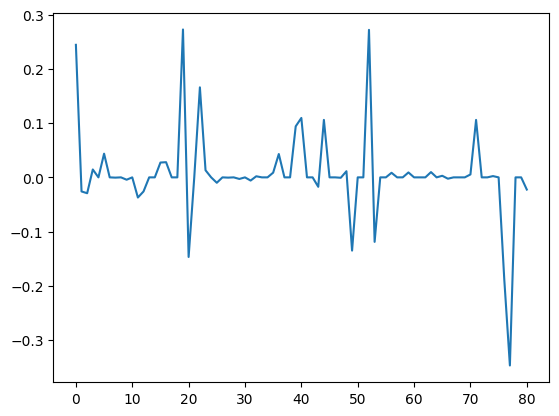

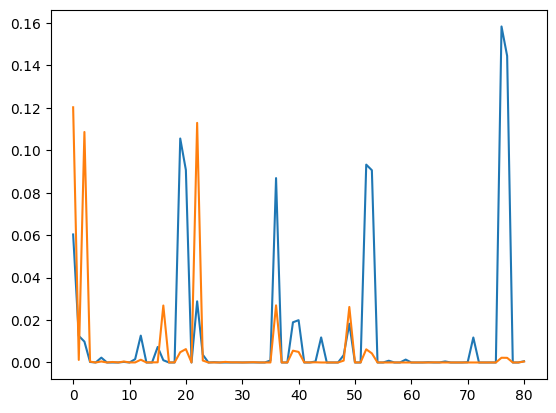

In [74]:
probb = (np.conjugate(m.forward(m.weights)) * m.forward(m.weights)).real

print(probb)
print(m.weights)
plt.plot(m.forward(m.weights))
plt.show()
prob_samples=np.average((np.conjugate(m.psi_batches) * m.psi_batches),axis=0).real

plt.plot(probb)
plt.plot(prob_samples)

plt.show()

[ 1.11425094  0.1066733  -0.13281154  0.11991409  0.87374428  1.03386124
  1.00703954  0.15885854  0.04883037  0.4778886   0.52254795  0.22313484
  0.10344538 -0.04685809 -0.03157857 -0.67677684  1.18405357  0.08668079
 -0.04012034  0.9770796   1.07882212  0.58954161  0.06574039  0.02853365
 -0.19619762  0.51848467 -0.23357604  0.1386339  -0.11802597  0.02993252
 -0.04093826  0.12126024 -0.01017823  0.00331436 -0.00269514 -0.02931829
 -0.06338598  0.17016889 -0.16600171 -0.48047097]


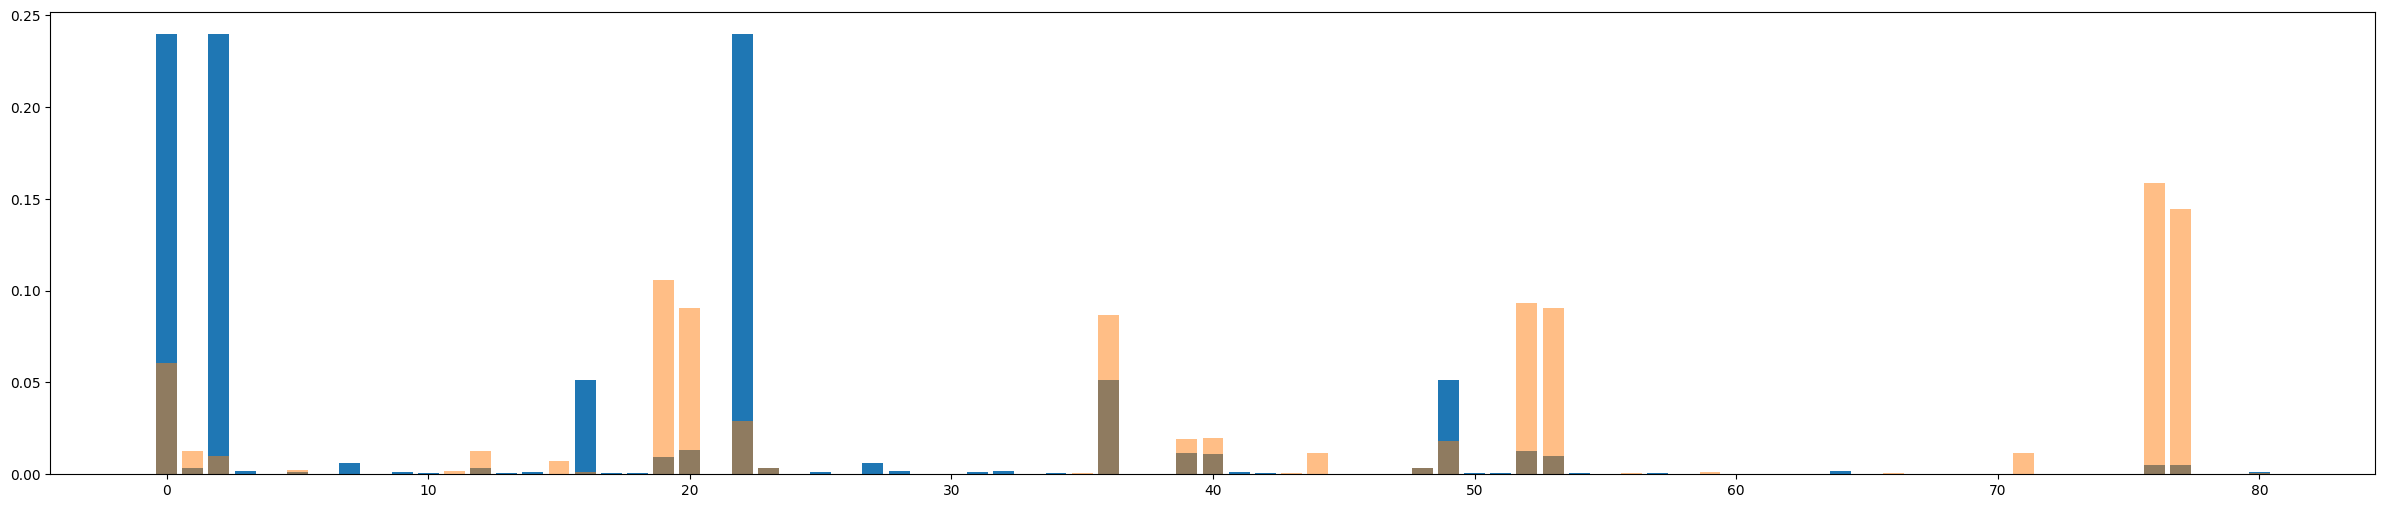

In [75]:
plt.figure(figsize=(30,6))

plt.bar(np.arange(psi0.shape[0]),(np.conjugate(psi0) * psi0).real)

plt.bar(np.arange(m.psi.shape[0]),probb,alpha=0.5)

#plt.bar(np.arange(m.psi.shape[0]),prob_samples,alpha=0.5)

print(m.weights)

In [76]:
fidelities=np.conjugate(np.einsum('ai,i->a',m.psi_batches,psi0))*np.einsum('ai,i->a',m.psi_batches,psi0)
print(np.average(fidelities))

for i in range(71,100):
    print(m.psi_batches[i].dot(NSMHamiltonian.hamiltonian.dot(m.psi_batches[i])))
    fidelities=np.conjugate(np.einsum('i,i->',m.psi_batches[i],psi0))*np.einsum('i,i->',m.psi_batches[i],psi0)
    print(np.average(fidelities))


0.45122927467915624
-23.638537803262576
0.9739102445079497
-23.62948297772087
0.9709591191227729
-23.575293655315587
0.9669229564946218
-23.63486100139919
0.9730496638595585
-23.558790382671244
0.9641946717384084
-23.625053943616845
0.9717504402676849
-23.60591143088264
0.9691817629219304
-23.64650766171894
0.9737759811371428
-23.60110403752474
0.969459735548871
-23.556591798899625
0.9638967472413226
-23.60014850516467
0.968723225089388
-23.60739459077705
0.9705382610626501
-23.632442105761275
0.9718960626477594
-23.591022353153
0.9688662591678947
-23.66676504037019
0.976519068492418
-23.573049056392016
0.9684736384560169
-23.60130396434094
0.9695235532235342
-23.567303826326604
0.9654610010058478
-23.550246608948342
0.9637967569428192
-23.574868844629318
0.9666312282860107
-23.60327077321158
0.971068432562901
-23.5832549006329
0.9677326033218359
-23.566901610371602
0.9638242470406128
-23.585016280628874
0.9675973905106784
-23.563906539346867
0.965550718550055
-23.57161008897995
0.9664